# 1. Inital Setup and Residual Calculation
- LR - HR Image Pairs: The process begins with low-resolution (LR) and high-resolution (HR) image pairs
- **Residual Image Calculation**: The difference between the HR image ($x_{H}$) and the upsampled LR image ($\text{up } x_{L}$) is calculated. This difference is known as the residual image ($x_0$).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# check GPU status
! nvidia-smi

Sun Dec 17 23:00:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              32W /  70W |    525MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Datasets
train_dataset = '/content/drive/MyDrive/MRIDataset/traindataset'
test_dataset = '/content/drive/MyDrive/MRIDataset/testdataset'
validate_dataset = '/content/drive/MyDrive/MRIDataset/validatedataset'
train_dataset_LR = '/content/drive/MyDrive/MRIDataset/traindataset_LR'
test_dataset_LR = '/content/drive/MyDrive/MRIDataset/testdataset_LR'
validate_dataset_LR = '/content/drive/MyDrive/MRIDataset/validatedataset_LR'

In [ ]:
# directory of MRIDataset

!ls /content/drive/MyDrive/MRIDataset/


 diffusion_model.pth   rdn_testdataset	    res_train	     traindataset
'old res'	       rdn_traindataset     res_validate     traindataset_LR
 rdn_encoderv1.pth     rdn_traindatasetv2   testdataset      validatedataset
 rdn_encoderv2.pth     res_test		    testdataset_LR   validatedataset_LR


In [ ]:
import os
from PIL import Image, ImageEnhance
import numpy as np
import random

def add_gaussian_noise(image, mean=0, std=10):
    """ Adds Gaussian noise to an image. """
    img_array = np.array(image)
    if img_array.shape[-1] == 4:  # Check for alpha channel
        rgb_array = img_array[:, :, :3]  # Extract RGB channels
        noise = np.random.normal(mean, std, rgb_array.shape)
        noisy_rgb_array = rgb_array + noise
        noisy_rgb_array = np.clip(noisy_rgb_array, 0, 255)
        img_array[:, :, :3] = noisy_rgb_array  # Replace RGB channels
    else:
        noise = np.random.normal(mean, std, img_array.shape)
        img_array = img_array + noise
        img_array = np.clip(img_array, 0, 255)
    noisy_image = Image.fromarray(img_array.astype('uint8'), 'RGBA' if img_array.shape[-1] == 4 else 'RGB')
    return noisy_image

def randomly_adjust_brightness(image, min_factor=1.0, max_factor=1.5):
    """ Randomly adjusts the brightness of the image. """
    rgb_image = image.convert('RGB')  # Apply brightness adjustment only to RGB channels
    enhancer = ImageEnhance.Brightness(rgb_image)
    factor = random.uniform(min_factor, max_factor)  # Randomly increase brightness
    enhanced_image = enhancer.enhance(factor)
    if image.mode == 'RGBA':
        alpha_channel = image.split()[-1]  # Extract and preserve the alpha channel
        return Image.merge('RGBA', (*enhanced_image.split(), alpha_channel))
    else:
        return enhanced_image

def downsample_add_noise_and_adjust_brightness(input_folder_path, output_folder_path, scale_factor=4):
    """ Downsamples, adds noise, and adjusts brightness of images. """
    os.makedirs(output_folder_path, exist_ok=True)

    for image_name in os.listdir(input_folder_path):
        image_path = os.path.join(input_folder_path, image_name)
        try:
            original_image = Image.open(image_path).convert('RGBA')
            original_size = original_image.size
            # Downsample and upsample
            small_image = original_image.resize((original_size[0]//scale_factor, original_size[1]//scale_factor), Image.BICUBIC)
            upsampled_image = small_image.resize(original_size, Image.BICUBIC)
            # Add noise
            noisy_image = add_gaussian_noise(upsampled_image)
            # Adjust brightness (only on RGB channels)
            bright_image = randomly_adjust_brightness(noisy_image)
            # Save the modified image
            bright_image.save(os.path.join(output_folder_path, image_name))
        except Exception as e:
            print(f"Error processing {image_name}: {e}")

In [ ]:
# Create simulated low-resolution images
downsample_add_noise_and_adjust_brightness(train_dataset, train_dataset_LR)
downsample_add_noise_and_adjust_brightness(test_dataset, test_dataset_LR)
downsample_add_noise_and_adjust_brightness(validate_dataset, validate_dataset_LR)

In [ ]:
from PIL import Image
import numpy as np
import os

def calculate_residuals(hr_folder_path, lr_folder_path, output_folder_path):
    """ Calculates the residuals between high-resolution and simulated low-resolution images. """
    os.makedirs(output_folder_path, exist_ok=True)

    for image_name in os.listdir(hr_folder_path):
        hr_image_path = os.path.join(hr_folder_path, image_name)
        lr_image_path = os.path.join(lr_folder_path, image_name)
        try:
            hr_image = Image.open(hr_image_path).convert('RGB')
            lr_image = Image.open(lr_image_path).convert('RGB')
            # Compute the residual
            residual_array = np.array(hr_image) - np.array(lr_image)
            residual_array = np.clip(residual_array, 0, 255)
            residual_image = Image.fromarray(residual_array.astype('uint8'), 'RGB')
            # Save the residual image
            residual_image.save(os.path.join(output_folder_path, image_name))
        except Exception as e:
            print(f"Error processing {image_name}: {e}")

In [ ]:
# Residuals folders
residual_train = '/content/drive/MyDrive/MRIDataset/res_train'
residual_test = '/content/drive/MyDrive/MRIDataset/res_test'
residual_validate = '/content/drive/MyDrive/MRIDataset/res_validate'

# Calculate residuals between original high-resolution and simulated low-resolution images
calculate_residuals(train_dataset, train_dataset_LR, residual_train)
calculate_residuals(test_dataset, test_dataset_LR, residual_test)
calculate_residuals(validate_dataset, validate_dataset_LR, residual_validate)

In [ ]:
import torch
import os
from PIL import Image
from torchvision.transforms import functional as TF

def add_alpha_channel(image):
    # Convert a PIL Image from RGB to RGBA
    r, g, b = image.split()
    alpha = Image.new('L', image.size, color=255)  # Create a new alpha channel filled with 255
    image.putalpha(alpha)  # Add the alpha channel
    return image

def convert_folder_to_rgba(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process each file in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_folder, file_name)
            output_path = os.path.join(output_folder, file_name)

            try:
                # Open the image file
                image = Image.open(input_path).convert('RGB')
                # Add an alpha channel
                image = add_alpha_channel(image)
                # Save the image
                image.save(output_path, format='PNG')  # Save as PNG to ensure alpha is preserved

                print(f"Converted and saved: {file_name}")
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")


In [ ]:
# Define your input and output folders
input_folder = '/content/drive/MyDrive/MRIDataset/res_validate'  # Update this to your input folder path
output_folder = '/content/drive/MyDrive/MRIDataset/res_validateA'  # Update this to your output folder path

# Convert all images in the folder to RGBA
convert_folder_to_rgba(input_folder, output_folder)

In [ ]:
# Residuals folders
residual_train = '/content/drive/MyDrive/MRIDataset/res_trainA'
residual_test = '/content/drive/MyDrive/MRIDataset/res_testA'
residual_validate = '/content/drive/MyDrive/MRIDataset/res_validateA'

# 2. Diffusion Process


*  **Goal** : Transform the residual image into a latent variable with a Gaussian distribution.
*  **Method** : Gradually add Gaussian noise to the residual image ($x_0$) over a series of steps, resulting in the latent variable ($x_T$).



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim):
        super().__init__()
        self.in_channels = in_channels  # Store the number of input channels
        self.out_channels = out_channels
        self.norm1 = nn.GroupNorm(1, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.proj = nn.Linear(emb_dim, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, t):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        # Conditioning
        t_proj = self.proj(t)
        t_proj = F.silu(t_proj)
        # Ensure t_proj has the same number of dimensions as h, removing any singleton dimensions
        # The shape of t_proj is now [batch_size, num_features, 1, 1] to broadcast correctly
        t_proj = t_proj.view(-1, self.out_channels, 1, 1)

        # Broadcast t_proj across the spatial dimensions of h
        h = h + t_proj

        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            x = self.shortcut(x)

        return x + h

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = Block(in_channels, out_channels, emb_dim)

    def forward(self, x, t):
        x = self.pool(x)
        return self.block(x, t)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.block = Block(in_channels, out_channels, emb_dim)

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        return self.block(x, t)


class UNet(nn.Module):
    def __init__(self, c_in, c_out, emb_dim=256):
        super().__init__()
        self.inc = Block(c_in, 64, emb_dim)
        self.down1 = Down(64, 128, emb_dim)
        self.down2 = Down(128, 256, emb_dim)
        self.down3 = Down(256, 512, emb_dim)
        self.up1 = Up(512 + 256, 256, emb_dim)
        self.up2 = Up(256 + 128, 128, emb_dim)
        self.up3 = Up(128 + 64, 64, emb_dim)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def forward(self, x, t):
        x1 = self.inc(x, t)
        x2 = self.down1(x1, t)
        x3 = self.down2(x2, t)
        x4 = self.down3(x3, t)
        x = self.up1(x4, x3, t)
        x = self.up2(x, x2, t)
        x = self.up3(x, x1, t)
        logits = self.outc(x)
        return logits



In [ ]:
import math
import torch
import torch.nn.functional as F

class Diffusion(nn.Module):
    def __init__(self, denoise_fn, beta_start=1e-4, beta_end=0.02, num_timesteps=1000, emb_dim=256):
        super().__init__()
        self.denoise_fn = denoise_fn
        self.num_timesteps = num_timesteps
        self.emb_dim = emb_dim
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.register_buffer('betas', torch.linspace(beta_start, beta_end, num_timesteps))

    def q_sample(self, x_start, t):
        # Sample x_t given x_0 and t
        noise = torch.randn_like(x_start)
        return x_start * torch.sqrt(1. - self.betas[t]) + noise * torch.sqrt(self.betas[t])

    def p_sample(self, x_t, t):
        # Reverse diffusion process
        t_emb = self._time_embedding(t, x_t.shape[0])
        predicted_noise = self.denoise_fn(x_t, t_emb)
        return self._predict_xstart(x_t, predicted_noise, t)

    def _predict_xstart(self, x_t, predicted_noise, t):
        # Handle both scalar and single-element tensor cases
        if isinstance(t, torch.Tensor):
            if t.numel() != 1:
                raise ValueError("t must be a scalar or a single-element tensor")
            t_scalar = t.item()  # Convert to Python scalar
        else:
            t_scalar = t  # t is already a scalar

        # Use t_scalar to index into betas
        beta_t = self.betas[t_scalar].item()  # Ensure it's a scalar

        # Calculations with beta_t
        sqrt_betas_t = torch.sqrt(torch.tensor(beta_t)).unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(x_t.device)
        sqrt_one_minus_betas_t = torch.sqrt(1. - torch.tensor(beta_t)).unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(x_t.device)

        # Calculate and return the predicted x_start
        return (x_t - sqrt_betas_t * predicted_noise) / sqrt_one_minus_betas_t


    def _time_embedding(self, t, batch_size):
        half_dim = self.emb_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        # Make sure t is a tensor and on the same device as self.betas
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, dtype=torch.float32, device=self.betas.device)
        else:
            t = t.to(dtype=torch.float32, device=self.betas.device)

        # Ensure t is a 1D tensor with the proper shape for broadcasting
        t = t.view(-1, 1)

        emb = emb.to(t.device).unsqueeze(0).repeat(batch_size, 1)  # Repeat for batch size
        t = t * emb
        emb = torch.cat([torch.sin(t), torch.cos(t)], dim=-1)

        return emb


    def forward(self, x, t):
        # Forward pass through the model
        t_emb = self._time_embedding(t, x.shape[0])
        predicted_noise = self.denoise_fn(x, t_emb)
        return self._predict_xstart(x, predicted_noise, t)


In [ ]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from pathlib import Path

class MRIDataset(Dataset):
    def __init__(self, manipulated_directory, hr_directory, transform=None):
        self.manipulated_directory = Path(manipulated_directory)
        self.hr_directory = Path(hr_directory)
        self.transform = transform
        self.manipulated_images = list(self.manipulated_directory.glob('*.png'))
        self.hr_images = list(self.hr_directory.glob('*.png'))

    def __len__(self):
        return len(self.manipulated_images)

    def __getitem__(self, idx):
        manipulated_img_path = self.manipulated_images[idx]
        hr_img_path = self.hr_images[idx]

        manipulated_image = read_image(str(manipulated_img_path)).float()
        hr_image = read_image(str(hr_img_path)).float()

        if self.transform:
            manipulated_image = self.transform(manipulated_image)
            hr_image = self.transform(hr_image)

        return manipulated_image, hr_image


In [ ]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.transforms import ConvertImageDtype, Normalize

# Define the loss function
loss_function = torch.nn.MSELoss()

def train_diffusion_model(residual_dir, hr_dir, epochs, batch_size, learning_rate):
    # Prepare the dataset
    transforms = T.Compose([
        ConvertImageDtype(torch.float32),  # Convert image to float32 tensor
        Normalize(mean=[0.485, 0.456, 0.406, 1.0], std=[0.229, 0.224, 0.225, 1.0])  # Normalize the image
    ])
    dataset = MRIDataset(residual_dir, hr_dir, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    unet = UNet(c_in=4, c_out=4, emb_dim=256).to(device)  # Assuming 4 channels (RGBA)
    model = Diffusion(unet, emb_dim=256).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    # Training loop for the diffusion model
    for epoch in range(epochs):
        for noisy_residuals, hr_images in dataloader:
            noisy_residuals, hr_images = noisy_residuals.to(device), hr_images.to(device)

            optimizer.zero_grad()

            batch_size = noisy_residuals.size(0)
            loss_accumulated = 0

            for i in range(batch_size):
                # Select the single image and its corresponding timestep
                single_noisy_residual = noisy_residuals[i].unsqueeze(0)  # Add batch dimension
                single_hr_image = hr_images[i].unsqueeze(0)
                t = torch.randint(0, model.num_timesteps, (1,), device=device).item()  # Single timestep scalar

                # Predict the clean residual for this single image
                predicted_residual = model.p_sample(single_noisy_residual, t)

                # Calculate and accumulate loss for this single image
                single_loss = loss_function(predicted_residual, single_hr_image)
                loss_accumulated += single_loss

            # Average loss across the batch and backward pass
            loss = loss_accumulated / batch_size
            loss.backward()
            optimizer.step()

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

    return model



# Example usage
residual_dir = '/content/drive/MyDrive/MRIDataset/res_trainA'
hr_dir = '/content/drive/MyDrive/MRIDataset/traindataset'
diffusion_model = train_diffusion_model(residual_dir, hr_dir, epochs=50, batch_size=16, learning_rate=1e-4)


In [ ]:
torch.save(diffusion_model.state_dict(), '/content/drive/MyDrive/MRIDataset/diffusion_modelv2.pth')

In [ ]:
! nvidia-smi

In [ ]:
# prompt: write me code that will clears all the memory of the cuda

torch.cuda.empty_cache()


Verifying if the diffusion process worked or not.

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.transforms import ConvertImageDtype, Normalize
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np


def calculate_metrics(noisy_image, target_image, denoised_image, win_size=5):
    mse = torch.nn.functional.mse_loss(denoised_image, target_image)
    noisy_image_np = noisy_image.squeeze().cpu().detach().numpy()
    target_image_np = target_image.squeeze().cpu().detach().numpy()
    denoised_image_np = denoised_image.squeeze().cpu().detach().numpy()

    # Ensure that the data range is correctly computed as the max minus the min
    data_range = target_image_np.max() - target_image_np.min()

    # PSNR
    psnr = compare_psnr(target_image_np, denoised_image_np, data_range=data_range)

    # SSIM - use the win_size parameter
    ssim = compare_ssim(
        target_image_np,
        denoised_image_np,
        data_range=data_range,
        win_size=win_size
    )

    return mse.item(), psnr, ssim


def verify_model_performance(model, hr_dataset_path, residual_dataset_path, device):
    model.eval()  # Set the model to evaluation mode

    # Assuming you have a DataLoader for your dataset
    dataset = MRIDataset(residual_dataset_path, hr_dataset_path)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    for i, (noisy, target) in enumerate(dataloader):
        noisy, target = noisy.to(device), target.to(device)

        # You need to define timesteps here
        timesteps = torch.randint(0, model.num_timesteps, (noisy.size(0),), device=device)

        # Generate denoised image using model
        with torch.no_grad():
            denoised = model(noisy, timesteps)

        # Move tensors to CPU for SSIM computation
        noisy_cpu = noisy.squeeze().cpu().detach().numpy()
        target_cpu = target.squeeze().cpu().detach().numpy()
        denoised_cpu = denoised.squeeze().cpu().detach().numpy()

        # Make sure to match the channel_axis to your data format
        # For example, if your data is 'CHW' (channels, height, width), channel_axis is 0
        # If your data is 'HWC', then channel_axis is 2
        channel_axis = 0  # or None if your images are grayscale
        ssim_noisy = compare_ssim(target_cpu, noisy_cpu, win_size=7, channel_axis=channel_axis)
        ssim_denoised = compare_ssim(target_cpu, denoised_cpu, win_size=7, channel_axis=channel_axis)

        print(f"SSIM Noisy: {ssim_noisy}, SSIM Denoised: {ssim_denoised}")

        if i >= 5:  # Just an example to limit the number of batches processed
            break

# Load your trained model
model_path = '/content/drive/MyDrive/MRIDataset/diffusion_modelv2.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Diffusion(UNet(c_in=4, c_out=4, emb_dim=256), emb_dim=256)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Verify the model performance
hr_dataset_path = '/content/drive/MyDrive/MRIDataset/traindataset'
residual_dataset_path = '/content/drive/MyDrive/MRIDataset/res_trainA'
verify_model_performance(model, hr_dataset_path, residual_dataset_path, device)


SSIM Noisy: 0.2586885094642639, SSIM Denoised: 0.10381289571523666
SSIM Noisy: 0.24183794856071472, SSIM Denoised: 0.04941599816083908
SSIM Noisy: 0.2844371795654297, SSIM Denoised: 0.1287805140018463
SSIM Noisy: 0.26772040128707886, SSIM Denoised: 0.11121818423271179
SSIM Noisy: 0.2757336497306824, SSIM Denoised: 0.05884033441543579
SSIM Noisy: 0.2374943196773529, SSIM Denoised: 0.07941330224275589


# 3. Encoding Low - Resolution images
* **LR Encoder**: The LR images are encoded using an RDN-based LR encoder
* **Output**: The encoded LR images ($x_\epsilon$) are prepared to guide the reverse diffusion process.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Inside DenseLayer class
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        # print("Input shape within DenseLayer:", x.shape)
        # print("Output shape after conv and relu:", out.shape)
        out = torch.cat([x, out], 1)
        # print("Output shape after concatenation:", out.shape)
        return out

# Inside DenseBlock class
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            input_channels = in_channels + i * growth_rate
            layers.append(DenseLayer(input_channels, growth_rate))
        self.dense_layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dense_layers(x)
        # print("Shape within DenseBlock:", out.shape)
        return out




# Inside RDNEncoder class
class RDNEncoder(nn.Module):
    def __init__(self, growth_rate, num_blocks, num_layers_per_block, in_channels=4, out_channels=4):
        super(RDNEncoder, self).__init__()
        self.initial_conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)

        blocks = []
        prev_out_channels = growth_rate
        for i in range(num_blocks):
            dense_block = DenseBlock(prev_out_channels, growth_rate, num_layers_per_block)
            blocks.append(dense_block)

            # Explicitly set prev_out_channels for the next block
            prev_out_channels += num_layers_per_block * growth_rate

        self.dense_blocks = nn.Sequential(*blocks)
        self.final_conv = nn.Conv2d(prev_out_channels, out_channels, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        # Initial convolution
        out = self.initial_conv(x)

        # Visualize the output of the initial convolution
        if hasattr(self, 'visualize') and self.visualize:
            self.visualize_layer_output(out, title="Output after initial_conv")

        # Pass through dense blocks
        out = self.dense_blocks(out)

        # Visualize the output of the last dense block
        if hasattr(self, 'visualize') and self.visualize:
            self.visualize_layer_output(out, title="Output after dense_blocks")

        # Final convolution
        out = self.final_conv(out)

        # Visualize the output of the final convolution
        if hasattr(self, 'visualize') and self.visualize:
            self.visualize_layer_output(out, title="Output after final_conv")

        return out

    def visualize_layer_output(self, tensor, title=""):
        # Assuming tensor is of shape [batch_size, channels, height, width]
        tensor = tensor.detach().cpu().squeeze(0)  # Remove batch dimension

        # Normalize each channel
        for c in range(tensor.size(0)):
            tensor[c] = (tensor[c] - tensor[c].min()) / (tensor[c].max() - tensor[c].min())

        # Only take the first 3 channels to visualize as RGB
        if tensor.size(0) > 3:
            tensor = tensor[:3]

        # Convert to PIL image and display
        plt.figure(figsize=(4, 4))
        plt.imshow(to_pil_image(tensor))
        plt.title(title)
        plt.axis('off')
        plt.show()




In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize the RDN Encoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rdn_encoder = RDNEncoder(growth_rate=64, num_blocks=3, num_layers_per_block=4, in_channels=4, out_channels=4).to(device)

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_model):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg_model
        self.mse_loss = nn.MSELoss()

    def forward(self, x, y):
        # Assume x and y are RGBA, convert to RGB by discarding the alpha channel
        x_rgb = x[:, :3, :, :]
        y_rgb = y[:, :3, :, :]
        # Normalize the images as required by VGG
        x_norm = (x_rgb + 1) / 2  # Adjust if your range is different
        y_norm = (y_rgb + 1) / 2
        vgg_x = self.vgg(x_norm)
        vgg_y = self.vgg(y_norm)
        return self.mse_loss(vgg_x, vgg_y)

# Initialize VGG model for feature extraction
vgg16 = models.vgg16(pretrained=True).features[:16].to(device)
vgg16.eval()
for param in vgg16.parameters():
    param.requires_grad = False

# Initialize perceptual loss function
perceptual_loss_fn = PerceptualLoss(vgg16)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rdn_encoder.parameters(), lr=0.001)



# Use the MRIDataset class for creating the dataset
train_dataset = '/content/drive/MyDrive/MRIDataset/traindataset'
train_dataset_LR = '/content/drive/MyDrive/MRIDataset/traindataset_LR'
lr_images = train_dataset_LR
hr_images = train_dataset

# Batch Size
batch_size = 8

# Create the dataset and data loader
trainrdndataset = MRIDataset(manipulated_directory=lr_images, hr_directory=hr_images)
train_loader = DataLoader(trainrdndataset, batch_size=batch_size, shuffle=True)

# Training loop with gradient accumulation and perceptual loss
num_epochs = 10
accumulation_steps = 4

for epoch in range(num_epochs):
    rdn_encoder.train()
    total_pixel_loss = 0.0
    total_perceptual_loss = 0.0

    for i, (lr_images, hr_images) in enumerate(train_loader):
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Forward pass
        sr_images = rdn_encoder(lr_images)
        pixel_loss = loss_fn(sr_images, hr_images) / accumulation_steps
        # Calculate perceptual loss using vgg features
        perc_loss = perceptual_loss_fn(sr_images, hr_images) / accumulation_steps
        # Combine losses
        loss = pixel_loss + perc_loss

        # Backward pass
        loss.backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

        total_pixel_loss += pixel_loss.item()
        total_perceptual_loss += perc_loss.item()

    # Print the losses
    print(f"Epoch [{epoch+1}/{num_epochs}], Pixel Loss: {total_pixel_loss:.4f}, Perceptual Loss: {total_perceptual_loss:.4f}")


In [ ]:
# Save the model's state dictionary
torch.save(rdn_encoder.state_dict(), 'rdn_encoder.pth')



In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Function to load and transform an image
def load_image(image_path):
    # Just convert image to tensor without normalization
    transform = T.Compose([
        T.ToTensor()
    ])
    image = Image.open(image_path).convert('RGBA')
    return transform(image)

# Function to convert a tensor to a PIL image
def tensor_to_pil(tensor):
    unloader = T.ToPILImage()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

# Function to save an image
def save_image(tensor, filename):
    # # Un-normalize and convert to PIL image
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = T.ToPILImage()(image)
    image.save(filename)

# Load the trained model
model_path = '/content/drive/MyDrive/MRIDataset/rdn_encoder.pth'
rdn_encoder = RDNEncoder(growth_rate=64, num_blocks=3, num_layers_per_block=4)
rdn_encoder.load_state_dict(torch.load(model_path))
rdn_encoder.eval()


# Define the folder containing the images
image_folder = '/content/drive/MyDrive/MRIDataset/traindataset_LR'
output_folder = '/content/drive/MyDrive/MRIDataset/rdn_traindataset'  # Replace with your desired output folder path

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process and save each image in the folder
for img_name in os.listdir(image_folder):
    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, img_name)
        # Extract filename to use for saving the processed image
        filename = os.path.basename(img_path)

        # Load and process the image
        test_image = load_image(img_path)
        with torch.no_grad():
            input_image = test_image.unsqueeze(0)  # Add batch dimension
            output_image = rdn_encoder(input_image)
            output_image = torch.clamp(output_image.squeeze(0), 0, 1)  # Remove batch dimension and clamp values

        # Save the processed image
        save_image(output_image, os.path.join(output_folder, filename))

print(f"Processed images have been saved to {output_folder}")



Processed images have been saved to /content/drive/MyDrive/MRIDataset/rdn_traindataset


# 4. Reverse Diffusion Process
* **Conditional Noise Predictor**: Utilizes a U-Net based structure to predict the noise added at each diffusion timestep
* **Reverse Steps**: Iteratively remove noise from the latent variable ($x_T$) over a finite number of steps ($T$).
* **Incorporatin LR Information**: During each reverse step, the encoded LR information ($x_e$) is added to guide the generation towards the corresponding HR space.

In [ ]:
! nvidia-smi

Mon Dec 18 07:58:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |    129MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# prompt: write me code that will clears all the memory of the cuda

torch.cuda.empty_cache()


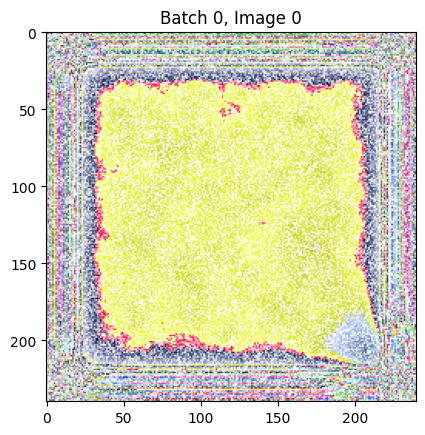

NameError: ignored

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import os


# Load the trained models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rdn_encoder = RDNEncoder(growth_rate=64, num_blocks=3, num_layers_per_block=4, in_channels=4, out_channels=4).to(device)
rdn_encoder.load_state_dict(torch.load('/content/drive/MyDrive/MRIDataset/rdn_encoderv2.pth'))
rdn_encoder.eval()

diffusion_model = Diffusion(UNet(c_in=4, c_out=4, emb_dim=256), emb_dim=256).to(device)
diffusion_model.load_state_dict(torch.load('/content/drive/MyDrive/MRIDataset/diffusion_modelv2.pth'))
diffusion_model.eval()

# Load data
dataset = MRIDataset('/content/drive/MyDrive/MRIDataset/traindataset_LR', '/content/drive/MyDrive/MRIDataset/traindataset', transform=None)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


def display_and_save_images(tensor, batch_index, output_folder, display_indices=[0, 1, 2], save_all=False):
    """Display and save images from tensor."""
    for i, image_tensor in enumerate(tensor):
        if i in display_indices:
            plt.imshow(to_pil_image(image_tensor.cpu()))
            plt.title(f"Batch {batch_index}, Image {i}")
            plt.show()

        if save_all or i in display_indices:
            pil_image = to_pil_image(image_tensor.cpu())
            pil_image.save(os.path.join(output_folder, filename))

def reverse_diffusion(dataloader, rdn_encoder, diffusion_model, device, num_timesteps, output_folder, display_indices, save_all):
    rdn_encoder.eval()
    diffusion_model.eval()
    output_tensors = []  # List to store output tensors

    for batch_index, (lr_images, _) in enumerate(dataloader):
        lr_images = lr_images.to(device)

        with torch.no_grad():
            # Encode LR images
            encoded_lr_images = rdn_encoder(lr_images)
            # Initialize with noise
            x_t = torch.randn_like(encoded_lr_images)

            # Reverse diffusion process
            for t in reversed(range(num_timesteps)):
                x_t = diffusion_model.p_sample(x_t, torch.tensor([t], device=device))
                torch.cuda.empty_cache()  # Free unused memory after each step

            output_tensors.append(x_t)

            # Display and save images
            display_and_save_images(x_t, batch_index, output_folder, display_indices, save_all)

            print(f"Processed batch {batch_index + 1}/{len(dataloader)}")

    # Optionally, save the output tensors as a .pth file
    torch.save(output_tensors, os.path.join(output_folder, 'reverse_diffusion_output_tensors.pth'))

    return output_tensors

# Example usage
num_timesteps = 1000
output_folder = '/content/drive/MyDrive/MRIDataset/enhanced_train'
display_indices = [0, 1, 2]
save_all = False  # Set to True to save all images

reverse_diffusion(dataloader, rdn_encoder, diffusion_model, device, num_timesteps, output_folder, display_indices, save_all)





In [ ]:
output_tensors = reverse_diffusion(dataloader, diffusion_model, rdn_encoder, device, num_timesteps)
torch.save(output_tensors, 'super_resolved_images.pth')


# 5. Reconstruction of the Super-Resolution Image
* Combining Residual and LR Image: The generated residual image from the reverse diffusion process is added to the upsampled LR image.
* Result: This step yields the final super-resolution image.

# 6. Results